### Importação de bibliotecas python

In [1]:
import os
import numpy as np
import pandas as pd
import neptune
from datetime import datetime
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Importação de módulos do projeto

In [2]:
os.chdir("..")

from src.utils import load_settings
from src.submission import KaggleSubmission

### Load Settings

In [3]:
settings = load_settings()

In [4]:
id_column        = settings["id_column"]
target_column    = settings["target_column"]
competition_name = settings["competition_name"]

### Read Data

In [5]:
train = pd.read_csv("data/train.csv")

In [6]:
test = pd.read_csv("data/test.csv")

### Exploratory Analysis

In [7]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
!cat data/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Análise descritiva

In [51]:
DescribeCount = test.\
    fillna('missing').\
    groupby(['PoolArea'])['Id'].\
    describe()[['count']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,PoolArea,count
0,0,1453.0
1,144,1.0
2,228,1.0
3,368,1.0
4,444,1.0
5,561,1.0
6,800,1.0


In [52]:
DescribeCount = train.\
    fillna('missing').\
    groupby(['PoolArea'])['SalePrice'].\
    describe()[['mean', 'count', 'std', 'min', 'max']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,PoolArea,mean,count,std,min,max
0,0,180404.7,1453.0,78168.9,34900.0,755000.0
1,480,160000.0,1.0,NaN,160000.0,160000.0
2,512,235000.0,1.0,NaN,235000.0,235000.0
3,519,250000.0,1.0,NaN,250000.0,250000.0
4,555,745000.0,1.0,NaN,745000.0,745000.0
5,576,171000.0,1.0,NaN,171000.0,171000.0
6,648,181000.0,1.0,NaN,181000.0,181000.0
7,738,274970.0,1.0,NaN,274970.0,274970.0


### Feature Engineering

In [69]:
dataprep_list =\
{
    "scale_adjust": {"var": ["YrSold"], "scale": [2010]},
    "continuous_to_binary": {"var":["PoolArea"], "threshold": [0]},
    "identity": ["LotArea", "OverallQual", "OverallCond", "Fireplaces"],
    "missing_class": ["Alley"],
    "binary_dummies": ["Street", "Alley", "SaleCondition", "LandSlope", "CentralAir"]
}

In [75]:
def feature_eng(data, dataprep_list):
    
    # Missing to classes
    data[dataprep_list["missing_class"]] = data[dataprep_list["missing_class"]].fillna('missing')
    
    # Binary to class
    binary_dummy = pd.get_dummies(data=data[dataprep_list["binary_dummies"]], drop_first = True)
    data = data.drop(dataprep_list["binary_dummies"], axis = 1)
    data[list(binary_dummy.columns)] = binary_dummy
    
    # continuous to binary
    data[dataprep_list["continuous_to_binary"]["var"][0] + "_binary"] = (train[dataprep_list["continuous_to_binary"]["var"][0]] > dataprep_list["continuous_to_binary"]["threshold"][0]).astype(int)
    
    # Alteração de escala
    data[dataprep_list["scale_adjust"]["var"][0] + "_adj"] = data[dataprep_list["scale_adjust"]["var"][0]] - dataprep_list["scale_adjust"]["scale"][0] 
    
    # Selected Variables
    X_columns = list(binary_dummy.columns) + dataprep_list["identity"] + [dataprep_list["scale_adjust"]["var"][0] + "_adj"] + [dataprep_list["continuous_to_binary"]["var"][0] + "_binary"]
    data = data[X_columns]

    return data

In [76]:
def target_eng(data, target_column, inverse = False):
    
    if(inverse):
        y = np.exp(data)
    else:
        y = np.log(np.ravel(data[[target_column]]))   
    
    return y

### Train-Validation split

In [77]:
X = feature_eng(train, dataprep_list)

In [78]:
X.head()

,Street_Pave,Alley_Pave,Alley_missing,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Mod,LandSlope_Sev,CentralAir_Y,LotArea,OverallQual,OverallCond,Fireplaces,YrSold_adj,PoolArea_binary
0,1,0,1,0,0,0,1,0,0,0,1,8450,7,5,0,-2,0
1,1,0,1,0,0,0,1,0,0,0,1,9600,6,8,1,-3,0
2,1,0,1,0,0,0,1,0,0,0,1,11250,7,5,1,-2,0
3,1,0,1,0,0,0,0,0,0,0,1,9550,7,5,1,-4,0
4,1,0,1,0,0,0,1,0,0,0,1,14260,8,5,1,-2,0


In [79]:
y = target_eng(train, target_column)

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1903)

### Neptune Experiments

In [81]:
neptune.init('adelmofilho/' + competition_name)

Project(adelmofilho/house-prices-advanced-regression-techniques)

### Grid Search

In [82]:
parameters = {'n_estimators':[300, 500, 600], 
              'max_features': ["auto"],
              'min_samples_split':[20, 50,75],
              'ccp_alpha': [0],
              'min_samples_leaf': [1,2,3]}

In [83]:
rf = RandomForestRegressor(criterion = "mse", random_state=0)

In [84]:
clf = GridSearchCV(rf, parameters, 
                   scoring = 'neg_mean_squared_error', 
                   verbose = 2, 
                   n_jobs=5)

In [85]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed:   32.8s finished


GridSearchCV(estimator=RandomForestRegressor(random_state=0), n_jobs=5,
             param_grid={'ccp_alpha': [0], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [20, 50, 75],
                         'n_estimators': [300, 500, 600]},
             scoring='neg_mean_squared_error', verbose=2)

In [86]:
clf.best_params_

{'ccp_alpha': 0,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 300}

### Treinamento com melhores parâmetros

In [87]:
rf_best = RandomForestRegressor(criterion = "mse", 
                                random_state=0,
                                max_features = clf.best_params_["max_features"],
                                n_estimators = clf.best_params_["n_estimators"],
                                min_samples_split = clf.best_params_["min_samples_split"],
                                ccp_alpha = clf.best_params_["ccp_alpha"],
                                min_samples_leaf = clf.best_params_["min_samples_leaf"])

In [88]:
rf_best.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0, min_samples_split=20, n_estimators=300,
                      random_state=0)

In [89]:
pkl_name = "{}.pkl".format(datetime.now().strftime("%Y-%b-%d-%H-%M-%S"))

In [90]:
pickle.dump(rf_best, open("models/" + pkl_name, 'wb'))

In [91]:
y_pred_train = rf_best.predict(X_train)

In [92]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_train

0.022439823104384332

### Avaliação de overfitting

In [93]:
y_pred_valid = rf_best.predict(X_valid)

In [94]:
mean_squared_error_valid = mean_squared_error(y_valid, y_pred_valid)
mean_squared_error_valid

0.0354344108214901

### Register Experiment

In [95]:
PARAMS = {"dataprep": dataprep_list,
          "grid_search": parameters}

In [96]:
experiment_name = "new features"

In [97]:
neptune.create_experiment(name=experiment_name, params=PARAMS)

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/adelmofilho/house-prices-advanced-regression-techniques/e/HOUSE-9


Experiment(HOUSE-9)

In [98]:
neptune.log_artifact("models/" + pkl_name)

In [99]:
neptune.log_metric('mean_squared_error_train',mean_squared_error_train)
neptune.log_metric('mean_squared_error_valid', mean_squared_error_valid)

### Avaliação dos resíduos

In [100]:
residues = pd.DataFrame()
residues["real"] = y_valid
residues["pred"] = y_pred_valid

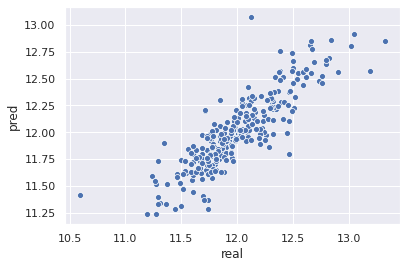

In [101]:
residuePlot = sns.scatterplot(x="real", y="pred", data=residues)
fig = residuePlot.get_figure()

In [102]:
neptune.log_image('residues', fig)

### Predição do conjunto de teste

In [103]:
X_test = feature_eng(test, dataprep_list)

In [104]:
y_pred_test = rf_best.predict(X_test)

In [105]:
y_pred_test_transform = target_eng(y_pred_test, target_column = target_column, inverse = True)

In [106]:
predictions = KaggleSubmission()

In [107]:
predictions["Id"] = test.Id
predictions["SalePrice"] = y_pred_test_transform

In [108]:
predictions.save('house-prices-advanced-regression-techniques', "Id", "SalePrice")

'submissions/house-prices-advanced-regression-techniques-2020-Jul-19-15-01-01.csv'

predictions.submit(message = "dummy LandSlope")

neptune.log_metric('mean_squared_error_test', )